In [2]:
# Imports and set-up

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
import statsmodels.formula.api as smf


In [3]:
# Pulling in the handy-dandy altair plots of excellence for use later


def base_chart(data, yvar, xvar, plottitle, yname, xname, dcolor="grey"):
    chart = (
        alt.Chart(data)
        .mark_point(color=dcolor, opacity=0.5)
        .encode(
            x=alt.X(xvar, title=xname, scale=alt.Scale(zero=False)),
            y=alt.Y(yvar, title=yname, scale=alt.Scale(zero=False)),
        )
        .properties(title=plottitle)
    )
    return chart


def get_reg_fit(data, yvar, xvar, alpha=0.05, dcolor="grey"):

    # Grid for predicted values
    x = data.loc[pd.notnull(data[yvar]), xvar]
    xmin = x.min()
    xmax = x.max()
    step = (xmax - xmin) / 100
    grid = np.arange(xmin, xmax + step, step)
    predictions = pd.DataFrame({xvar: grid})

    # Fit model, get predictions
    model = smf.ols(f"{yvar} ~ {xvar}", data=data).fit()
    model_predict = model.get_prediction(predictions[xvar])
    predictions[yvar] = model_predict.summary_frame()["mean"]
    predictions[["ci_low", "ci_high"]] = model_predict.conf_int(alpha=alpha)

    # Build chart
    reg = (
        alt.Chart(predictions)
        .mark_line(color=dcolor)
        .encode(
            x=alt.X(xvar),
            y=alt.Y(yvar),
        )
    )
    ci = (
        alt.Chart(predictions)
        .mark_errorband(color=dcolor, opacity=0.2)
        .encode(
            x=xvar,
            y=alt.Y("ci_low"),
            y2="ci_high",
        )
    )
    chart = ci + reg

    return predictions, chart


#### Introduction

Someone approached me not long ago and said something interesting that got me thinking a bit. They said something to the effect of: "you have to buy this thing, the value is going to skyrocket soon, and I wouldn't want you to miss out. I've been watching this for a long time, and I'm telling you, it's going to be big." The appeal was compelling, especially to the innate psychological tendencies that make us human (the kids call this 'FOMO' or 'Fear Of Missing Out'). But something felt off, and I ultimately brushed off the opportunity, said my thanks, and moved on without much further thought.

The 'golden opportunity' (pun intended) presented to me was in precious metal investments, particularly silver. The logic was that the price of silver was tied to the price of gold, and silver was significantly undervalued relative to gold at that time. During the winter holidays of 2022, when this conversation happened, the theory was that the gold-silver price ratio was 7:1. That balance made the theoretical price point for silver in the neighborhood of $270/ounce, a price that outpaced the going spot by over 10x. This failed common sense check led me to walk away, but I also never thoroughly investigated the claim until now.

#### Data

For this exploration, I'll be using monthly average prices for various commodities that I've collected from the International Monetary Fund (IMF); the data can be found [at this link](https://www.imf.org/en/Research/commodity-prices). The IMF maintains historical prices on a wide variety of commodities and indices from around the world, which it aggregates as a monthly average price in the form I collected.

The dataset contains 94 columns, each representing a unique commodity (from Gold, Silver, and Platinum to Beverage Price Index and Agricultural Price Index). The data spans from January 1990 through December 2022; however, some commodities or indices do not have observations for the entire time (the majority of missingness is on the front end of the data). I'll narrow the focus of this analysis to just precious metals and some popular commodities and omit some of the indices and other lesser-known commodities. The chief relationship I will interrogate is gold and silver, but I'll also look at other associations to see if anything interesting emerges.

The first step will be to ingest the data and examine the resulting dataframe to see what challenges may arise. I already took a look at the data in the excel file when it completed downloading, and I suspect that I will have to do some transformations to a few areas of the data to make this analysis more manageable. I'll start with the import and walk systematically through the cleaning to see how it goes.

In [4]:
# Data ingest

price_df = pd.read_excel(
    "../10_source_data/external-datajanuary.xls"
)
# price_df.head(5)


#### Data Cleaning

From an inspection of the data, several challenges are immediately apparent:
* There are a lot of excess columns that I already know I don't need. I'll drop some of the unnecessary columns.
* There appear to be three meaningless rows that are an artifact of the excel format. I'll drop these.
* The month format is going to require transformation to a DateTime format. For example, it is currently stored as "1990M1" to represent January 1990. I'll transform this to a DateTime format.

I'll begin by addressing these things one at a time to arrive at a final dataset.

In [5]:
# Data cleaning

# First problem: columns

# First, print the column header and value in the first row together to see what we're working with
# for col in price_df.columns:
#     print(col, price_df[col][0])

# Then subset the data to only the columns we want
cols = [
    "Commodity",
    "PMETA",
    "PPMETA",
    "PNGAS",
    "PALUM",
    "PCOFFROB",
    "PCOPP",
    "PCOTTIND",
    "PLEAD",
    "PNICK",
    "PTIN",
    "PURAN",
    "PCOBA",
    "PGOLD",
    "PSILVER",
    "PPALLA",
    "PPLAT",
    "Unnamed: 90",
]
price_df = price_df[cols]

# Then rename the columns to the first word of the value in the first row
price_df.columns = [
    "Date",
    "Base Metals",
    "Precious Metals",
    "Natural Gas",
    "Aluminum",
    "Coffe Robusta",
    "Copper",
    "Cotton",
    "Lead",
    "Nickel",
    "Tin",
    "Uranium",
    "Cobalt",
    "Gold",
    "Silver",
    "Palladium",
    "Platinum",
    "Lithium",
]


In [6]:
# Second problem: rows

# Drop the first three rows
price_df = price_df.drop([0, 1, 2])


In [7]:
# Third problem: date formats

# Convert the date column to a datetime object
price_df["Date"] = pd.to_datetime(price_df["Date"], format="%YM%m")

# Reset the index
price_df = price_df.reset_index(drop=True)


#### Exploratory Data Analysis

To examine the price relationships, I'll begin with a series of plots to do a quick visual inspection of the information to see what emerges. From there, I'll identify some relationships of interest and carry on with a deeper dive into those areas.

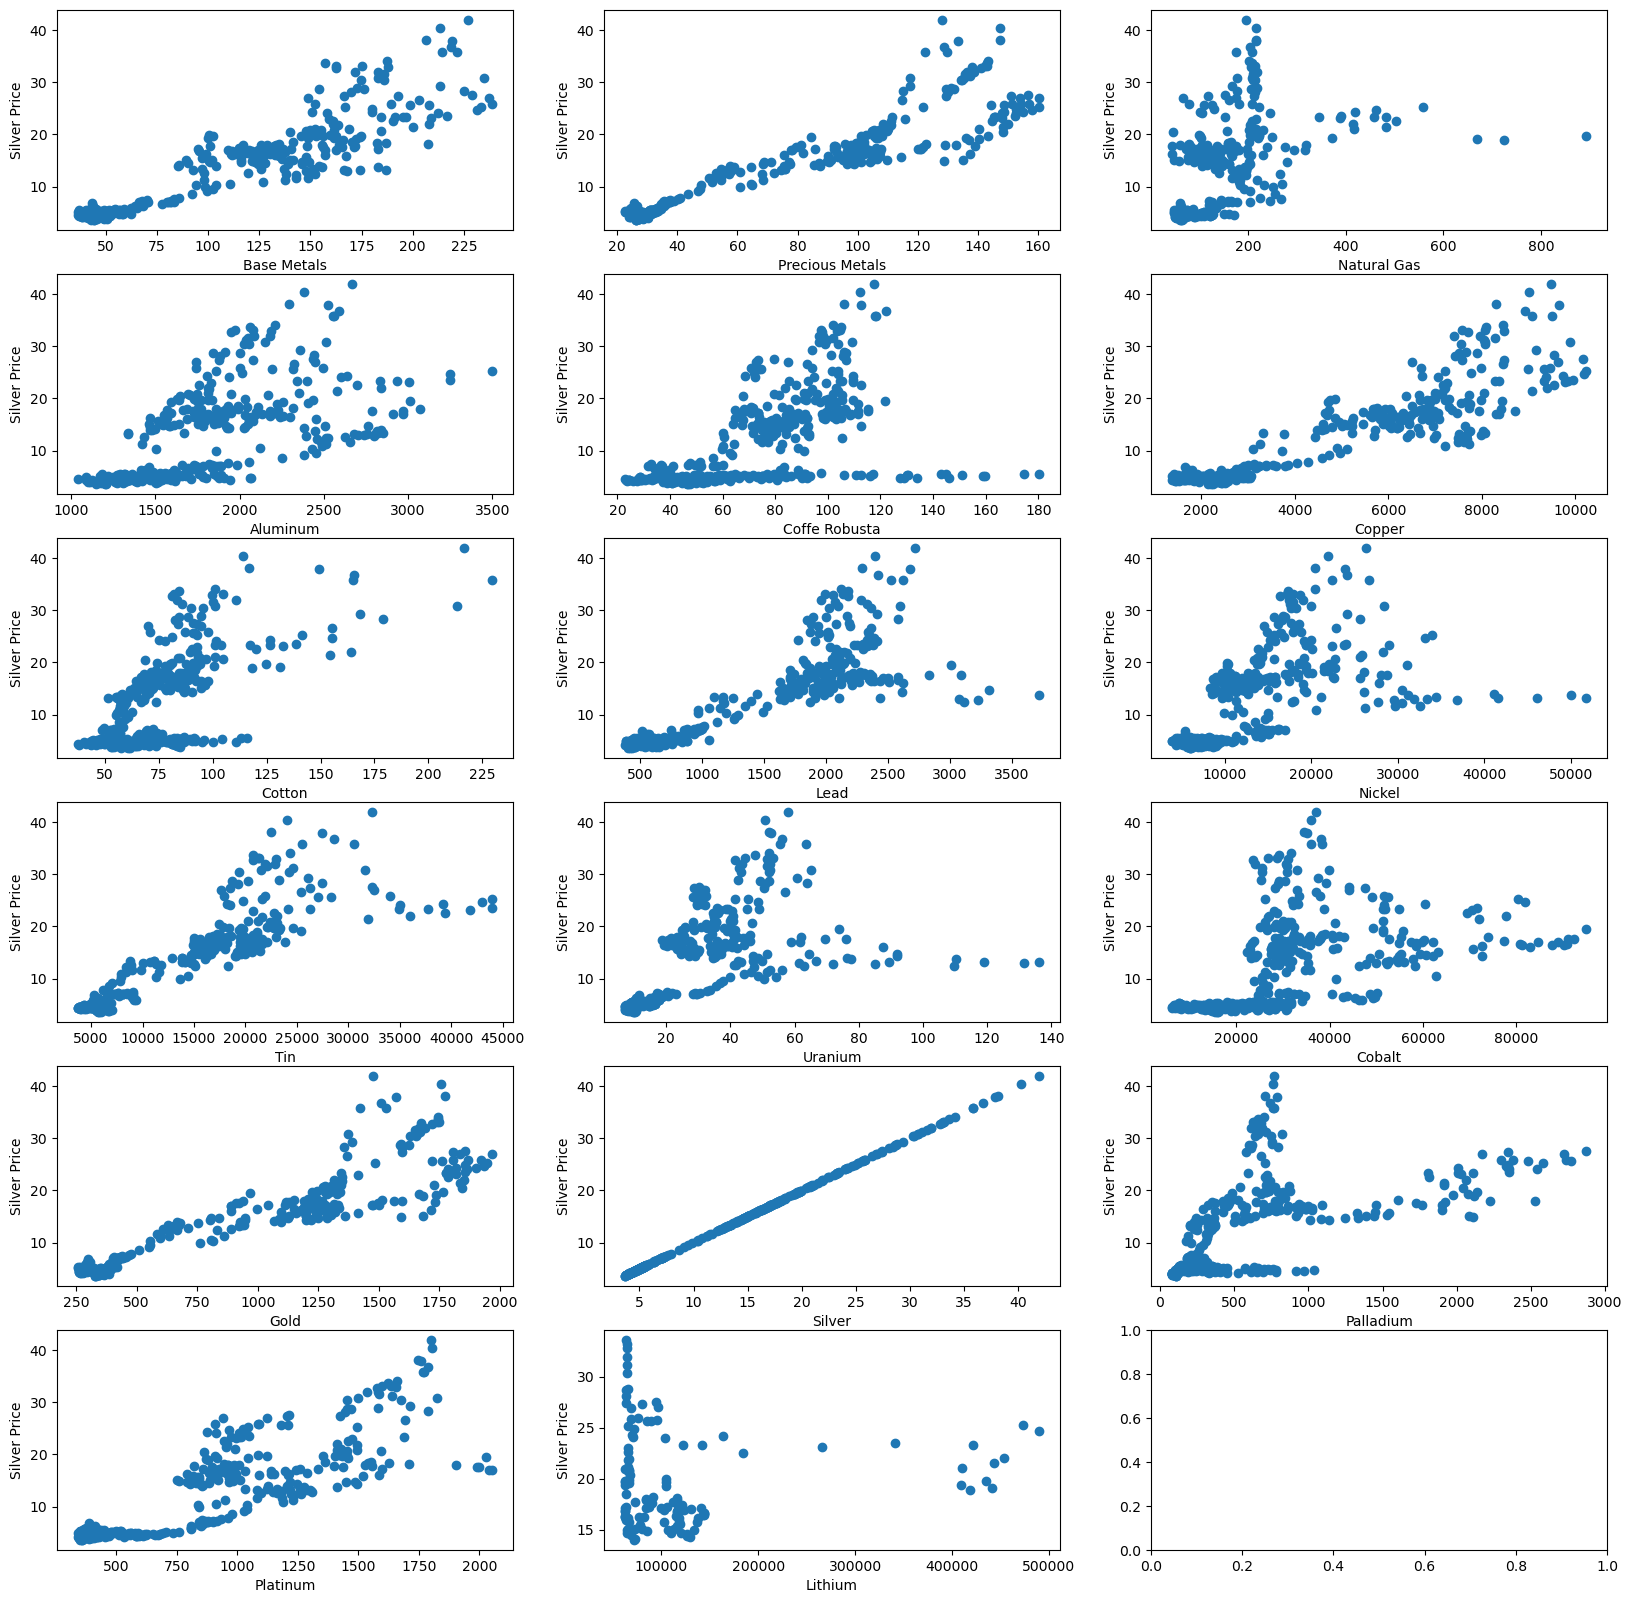

In [8]:
# A matrix of plots with all the columns against the silver price
fig, axs = plt.subplots(6, 3, figsize=(20, 20))
for i, col in enumerate(price_df.columns[1:]):
    axs[i // 3, i % 3].scatter(price_df[col], price_df["Silver"])
    axs[i // 3, i % 3].set_ylabel("Silver Price")
    axs[i // 3, i % 3].set_xlabel(col)


The matrix of plots above shows the prices of the commodities and indices I selected as predictor variables, with the price of silver as the outcome variable. There are a couple of things that I found interesting about this group. First, several commodities appear to have a strong positive relationship with silver, but many of those relationships weaken (sometimes significantly) after a specific price point is surpassed. This effect is best observed on the graph with the price of tin as the predictor. Around a tin price of $17,500, the relationship with silver appears to weaken and level off. This follows how these commodities behave: the price of one item does not affect silver; the prices are symptoms of broader economic sentiment and concepts about where the costs should be. In short, the prices are correlated but not causally related. 

The second observation is that the price of silver has a strong positive relationship with the prices of several commodities. I'll downselect these predictors and examine them further in the next section:
* Gold
* Platinum
* Tin
* Lead
* Copper
* Aluminum

The correlation evident with the precious metal indices is notable but also expected, so I will exclude those from future analysis into the price behavior of silver.

In [9]:
# Downselect the data to only the final predictors of interest

final_cols = ["Date", "Silver", "Gold", "Platinum", "Tin", "Lead", "Copper", "Aluminum"]
final_df = price_df[final_cols].copy()
# final_df.head(5)

# convert columns [1:] to numeric
final_df[final_df.columns[1:]] = final_df[final_df.columns[1:]].apply(
    pd.to_numeric, errors="coerce"
)


In [10]:
# Copper Analysis

copp_chart = base_chart(
    final_df,
    "Silver",
    "Copper",
    "Correlation between Copper and Silver",
    "Silver Price (USD)",
    "Copper Price (USD)",
)
copp_pred, copp_reg = get_reg_fit(
    final_df,
    "Silver",
    "Copper",
    dcolor="green",
)

# Platinum Analysis

plat_chart = base_chart(
    final_df,
    "Silver",
    "Platinum",
    "Correlation between Platinum and Silver",
    "Silver Price (USD)",
    "Platinum Price (USD)",
)
plat_pred, plat_reg = get_reg_fit(
    final_df,
    "Silver",
    "Platinum",
    dcolor="green",
)

# aluminum analysis


alum_chart = base_chart(
    final_df,
    "Silver",
    "Aluminum",
    "Correlation between Aluminum and Silver",
    "Silver Price (USD)",
    "Aluminum Price (USD)",
)
alum_pred, alum_reg = get_reg_fit(
    final_df,
    "Silver",
    "Aluminum",
    dcolor="green",
)

# Display the charts
copp_chart + copp_reg


alt.LayerChart(...)

In [11]:
plat_chart + plat_reg


alt.LayerChart(...)

In [12]:
# Display the charts
alum_chart + alum_reg


alt.LayerChart(...)

**Copper, Platinum, and Aluminum**

Silver appears to have a strong, positive correlation with the prices of both copper and platinum. The relationship to aluminum is strong and positive, but appears to weaken a little bit as the prices increase. Interestingly, there does not appear to be a "break point" anywhere in the data where the relationship changes or is invalidated. The confidence intervals widen for the regression lines as the prices of the predictors increase, but not enough to raise serious questions about the validity of the relationships.

In [13]:
# Gold Analysis

# split the data into gold >1300 and gold <1300
gold_1300_greater = final_df[final_df["Gold"] > 1300].copy()
gold_1300_less = final_df[final_df["Gold"] < 1300].copy()

# Make charts
gold_chart = base_chart(
    final_df,
    "Silver",
    "Gold",
    "Correlation between Gold and Silver",
    "Silver Price (USD)",
    "Gold Price (USD)",
)
gold_pred, gold_reg = get_reg_fit(
    final_df,
    "Silver",
    "Gold",
    dcolor="black",
)
gold_13_pred_great, gold_13_reg_great = get_reg_fit(
    gold_1300_greater, "Silver", "Gold", dcolor="orange"
)
gold_13_pred_less, gold_13_reg_less = get_reg_fit(
    gold_1300_less, "Silver", "Gold", dcolor="orange"
)

# Display the charts
gold_chart + gold_reg + gold_13_reg_great + gold_13_reg_less


alt.LayerChart(...)

**Gold**

Silver has an interesting price relationship to gold. There are two lines plotted: a standard linear regression (black) and a split regression with bifurcated data when gold exceeds $1300. The split relationship brings out an interesting point in this relationship. There is a very narrow confidence interval up to a gold price of $1300. However, once the threshold is surpassed, the confidence interval widens significantly, and the slope levels off somewhat. This phenomenon is worth further investigation before modeling an accurate prediction from this relationship.

In [14]:
# Tin Analysis

# split tin at 17500
tin_17500_greater = final_df[final_df["Tin"] > 17500].copy()
tin_17500_less = final_df[final_df["Tin"] < 17500].copy()

tin_chart = base_chart(
    final_df,
    "Silver",
    "Tin",
    "Correlation between Tin and Silver",
    "Silver Price (USD)",
    "Tin Price (USD)",
)
tin_pred, tin_reg = get_reg_fit(
    final_df,
    "Silver",
    "Tin",
    dcolor="black",
)
tin_17_pred_great, tin_17_reg_great = get_reg_fit(
    tin_17500_greater, "Silver", "Tin", dcolor="red"
)
tin_17_pred_less, tin_17_reg_less = get_reg_fit(
    tin_17500_less, "Silver", "Tin", dcolor="red"
)

# Display the charts
tin_chart + tin_reg + tin_17_reg_great + tin_17_reg_less


alt.LayerChart(...)

**Tin**

Similar to its behavior when predicted by gold, the price of silver has threshold issues when it is predicted by tin. The confidence interval widens significantly when the price of tin exceeds $17,500. Beyond that point, there is a much wider confidence interval, and the slope of the regression line decreases significantly compared to below the price threshold.

In [15]:
# Lead Analysis

# split lead at 1750
lead_1750_greater = final_df[final_df["Lead"] > 1750].copy()
lead_1750_less = final_df[final_df["Lead"] < 1750].copy()

lead_chart = base_chart(
    final_df,
    "Silver",
    "Lead",
    "Correlation between Lead and Silver",
    "Silver Price (USD)",
    "Lead Price (USD)",
)
lead_pred, lead_reg = get_reg_fit(
    final_df,
    "Silver",
    "Lead",
    dcolor="black",
)
lead_17_pred_great, lead_17_reg_great = get_reg_fit(
    lead_1750_greater, "Silver", "Lead", dcolor="red"
)
lead_17_pred_less, lead_17_reg_less = get_reg_fit(
    lead_1750_less, "Silver", "Lead", dcolor="red"
)

# Display the charts
lead_chart + lead_reg + lead_17_reg_great + lead_17_reg_less


alt.LayerChart(...)

**Lead**

Silver's price relationship with lead is the most troublesome of the possible predictors. Beyond a threshold price of $1750, there is almost no value to the interaction. The previously strong correlation weakens significantly, and the slope is badly affected by a series of data points in the lower-right portion of the graph, as well as a complementary group rising out of the center. This is a relationship that I would not trust for modeling purposes, and I will exclude it from further analysis.

#### Summary

This exploratory analysis shows that silver has a strong, positive relationship with many commodities (as they likely do with each other as well). However, some relationships are stronger than others, and some may not even be linear. To address this question further, I'll continue to model fitting with the final subset of the data, but here are the key takeaways from this exploratory analysis:

* Silver has a strong, positive relationship with the price of gold, but the relationship might not be linear. A threshold price of $1300 causes the relationship to change. This somewhat addresses the root purpose of this analysis but raises further questions to be discussed in model fitting.

* Silver has a strong, positive relationship with copper, platinum, and aluminum prices. In a future study, I will include these metals as possible predictors during model fitting.

* Silver has suspect relationships with the prices of tin and lead. Due to the suspicious nature of both regressions, I will exclude them from further analysis.

**In short, gold and silver are correlated, but there are certainly issues which I'll continue digging into.**

In [18]:
# make a final dataframe with date, silver, gold, aluminum, platinum, and copper

export_df = final_df[["Date", "Silver", "Gold", "Aluminum", "Platinum", "Copper"]].copy()

# export to 30_intermediate_files
export_df.to_csv("../30_intermediate_files/regression_dataset.csv", index=False)